# Benchmarking of Sleep/Wake Detection Algorithms on a Large Cohort using Actigraphy, HRV and Respiration Information

This notebook gives a detailed overview over the results presented in the Paper "Benchmarking of Sleep/Wake Detection Algorithms on a Large Cohort using Actigraphy, HRV and Respiration Information" submitted to the IEEE-EMBS International Conference on Biomedical and Health Informatics

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import biopsykit as bp
from biopsykit.utils.dataframe_handling import multi_xs
from biopsykit.stats import StatsPipeline


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from fau_colors import register_cmaps
register_cmaps()

sns.set_theme(context="talk", style="white", palette="faculties", font_scale=1.2)

%matplotlib widget

## Result DataFrame

In [4]:
# read result dataframe in long format
df = pd.read_pickle(Path.cwd().joinpath("full_result_df.pkl"))

In [5]:
# display full result dataframe
df

data
algorithm type algorithm modality        subject metric                             
ML             AdaBoost  ACT             0027    accuracy                  91.520979
                                                 bed_interval_end        1154.000000
                                                 bed_interval_start       120.000000
                                                 f1                        95.265983
                                                 getup_latency              0.000000
...                                                                              ...
DL             TCN       ACT + HRV + RRV 6807    sleep_onset_latency        3.000000
                                                 specifity                 85.000000
                                                 total_sleep_duration      86.000000
                                                 wake_after_sleep_onset    26.000000
                                                 wake_onset                76.000000

[116928 rows x 1 columns]

## Result of Algorithms and Modalities according to Performance metrics

In [6]:
result_df = multi_xs(df, ["accuracy", "precision","recall", "f1", "kappa", "specifity"], level="metric")

In [7]:
# calculate mean & std
result_df = result_df.groupby(["algorithm type", "algorithm","modality", "metric"])

In [8]:
# shape DataFrame
mean_std_df = result_df.agg(
    ["mean"]
)
mean_std_df = mean_std_df.unstack("metric")

In [9]:
# method to highlight the maximum value for each performance measure
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

mean_std_df.style.apply(highlight_max, props='color:white;background-color:darkblue', axis=0)

In [10]:
mean_std_df.style.background_gradient()

In [11]:
mean_std_df.unstack("modality").stack("metric").style.background_gradient(axis=1)

## Plot Results Algorithm-wise

In [12]:
df_metric = multi_xs(df, ["accuracy", "kappa", "specifity"], level="metric")

In [13]:
def calculate_stats(df_slice):
    dict_stats = {}

    for metric in ["accuracy", "kappa", "specifity"]:
        steps = [
            # ("prep", "normality"),
            #("test", "pairwise_ttests")
            ("test", "kruskal"),
            ("posthoc", "pairwise_ttests"),
        ]

        params = {
            "dv": "data",
            "between": "modality",
            #"subject": "subject",
            "groupby": ["algorithm"],
            "parametric": False,
            #"multicomp": {"levels": ["algorithm"]},
        }

        df_slice_metric = df_slice.xs(metric, level="metric")
        pipeline = StatsPipeline(steps, params, round=4)
        pipeline.apply(df_slice_metric)

        dict_stats[metric] = pipeline
        
    dict_brackets = {
    key: dict_stats[key].sig_brackets("posthoc", stats_type="between", plot_type="multi", x="algorithm", stats_effect_type="between")
    for key in ["accuracy", "kappa", "specifity"]
}
    box_pairs = {key: val[0] for key, val in dict_brackets.items()}
    pvalues = {key: val[1] for key, val in dict_brackets.items()}
        
    return box_pairs, pvalues

In [14]:
def plot_algorithm_result(df, algorithm):  
    df_plot = multi_xs(df, [algorithm], level="algorithm")
    box_pairs, pvalues = calculate_stats(df_plot)
    fig, axs = plt.subplots(figsize=(15, 6), ncols=3)

    features = {"accuracy": "accuracy", "kappa": "kappa", "specifity": "specifity"}


    fig, axs = bp.plotting.multi_feature_boxplot(
        data=df_plot,
        x="algorithm",
        y="data",
        hue="modality",
        hue_order=["ACT", "ACT + HRV", "ACT + HRV + RRV"],
        group="metric",
        features=features,
        stats_kwargs={
            "box_pairs": box_pairs,
            "pvalues": pvalues,
            "fontsize": "medium",
            "text_offset": -10,
            "verbose": False
        },
        ylabels={"accuracy": "Accuracy [%]", "kappa": "Cohen's Kappa", "specifity": "Specificity [%]"},
        axs=axs,
    )
    fig.tight_layout(rect=(0, 0,1, 1), pad=2.5)
    handles, labels = axs[0].get_legend_handles_labels()

    for ax, metric in zip(axs, features):
        ax.legend().remove()
        ax.set_xlabel("Algorithm")
        ax.tick_params(reset=True, right=False, top=False)


    fig.legends[0].remove()
    plt.legend(ncol=3,bbox_to_anchor=(0.3, 1.2))

    axs[0].set_yticks([i for i in np.arange(40, 110, 10)])
    axs[1].set_yticks([i for i in np.arange(-0.4, 1.1, 0.2)])
    axs[1].set_ylim(-0.35, 1.4)
    axs[2].set_yticks([i for i in np.arange(0, 110, 20)])


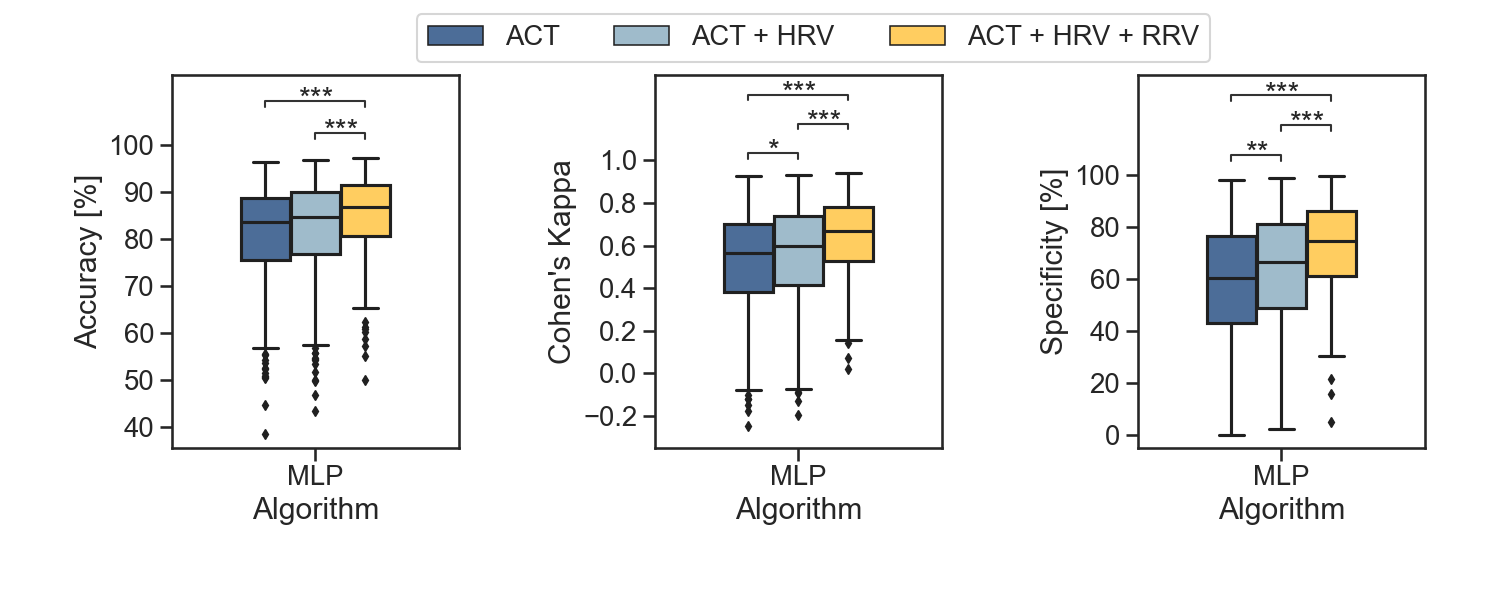

In [15]:
plot_algorithm_result(df_metric, "MLP")

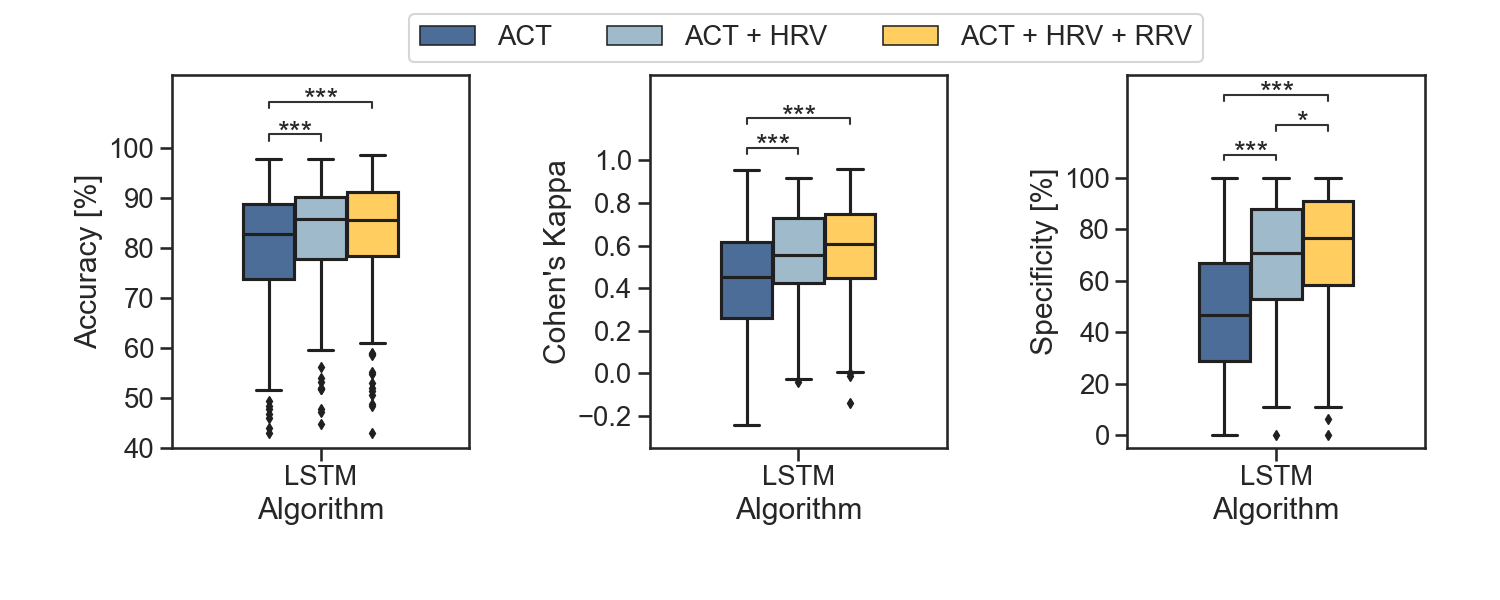

In [16]:
plot_algorithm_result(df_metric, "LSTM")

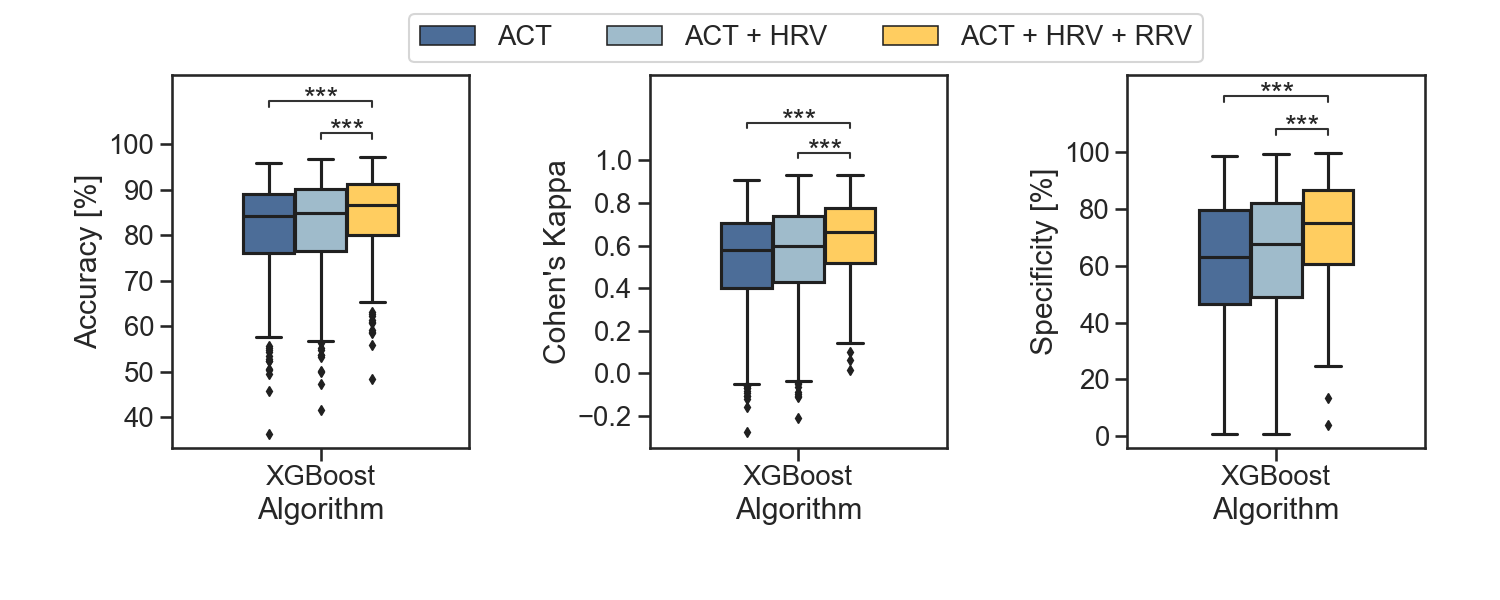

In [17]:
plot_algorithm_result(df_metric, "XGBoost")

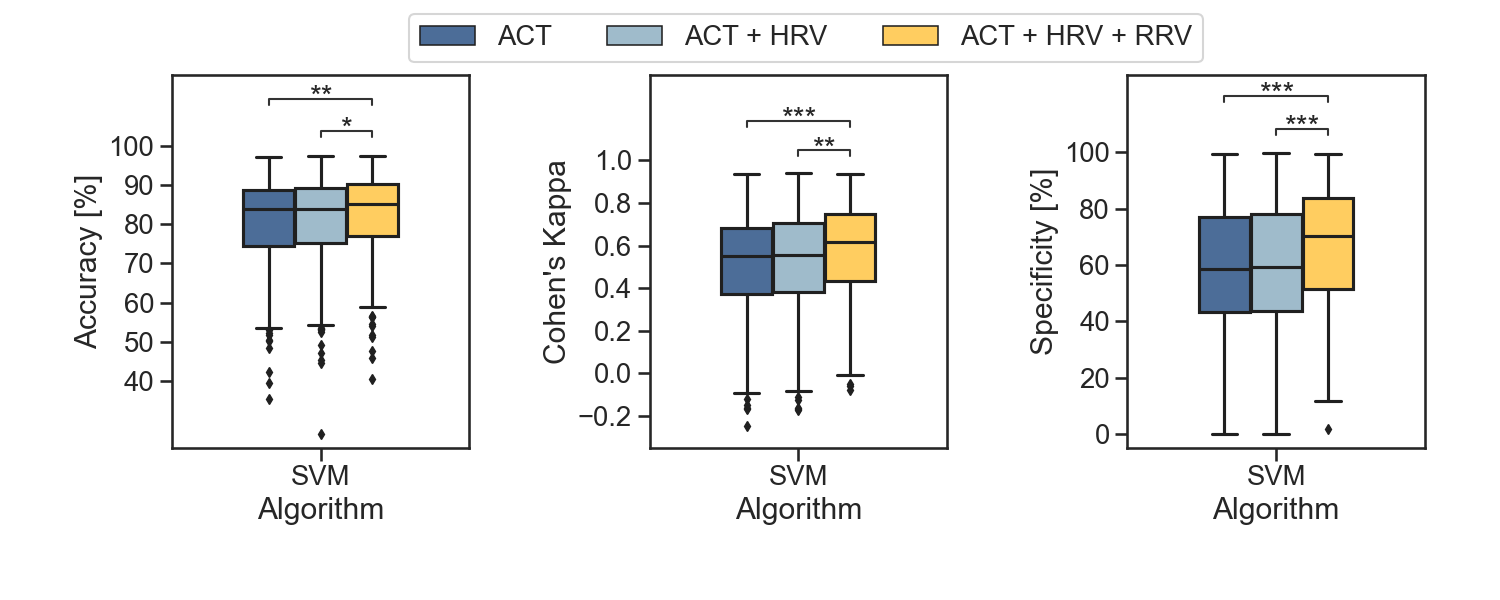

In [18]:
plot_algorithm_result(df_metric, "SVM")

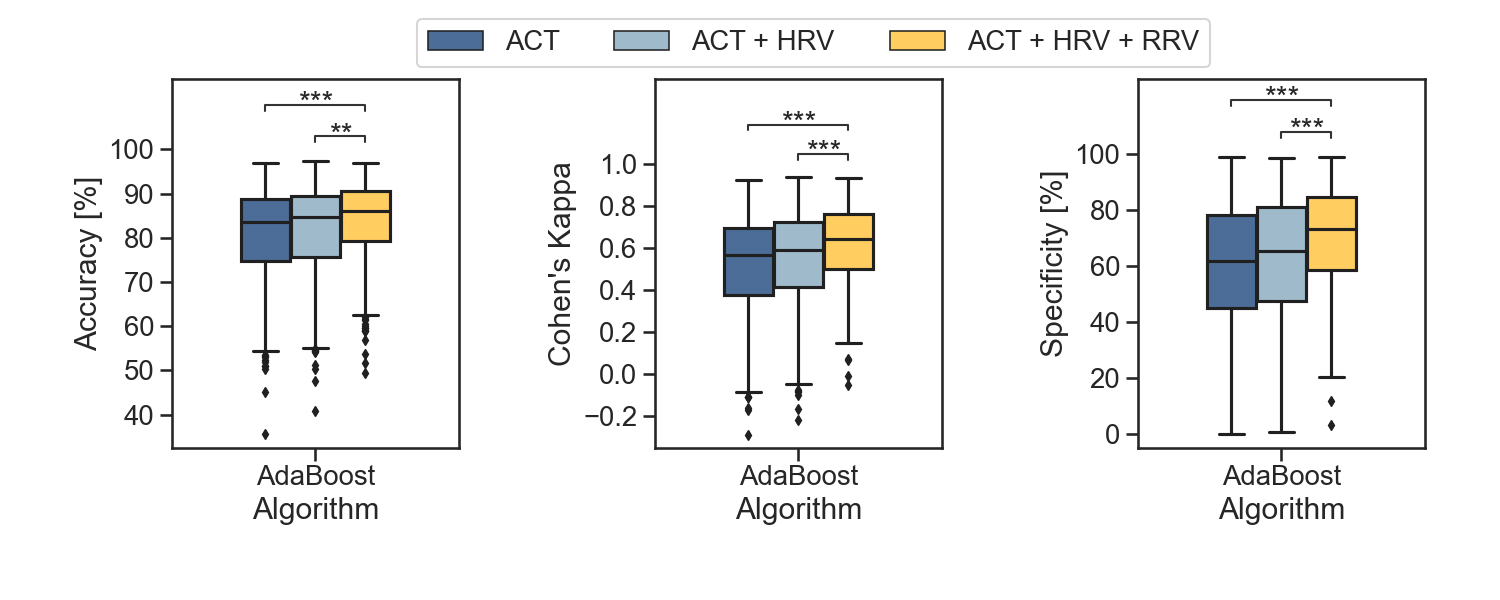

In [19]:
plot_algorithm_result(df_metric, "AdaBoost")

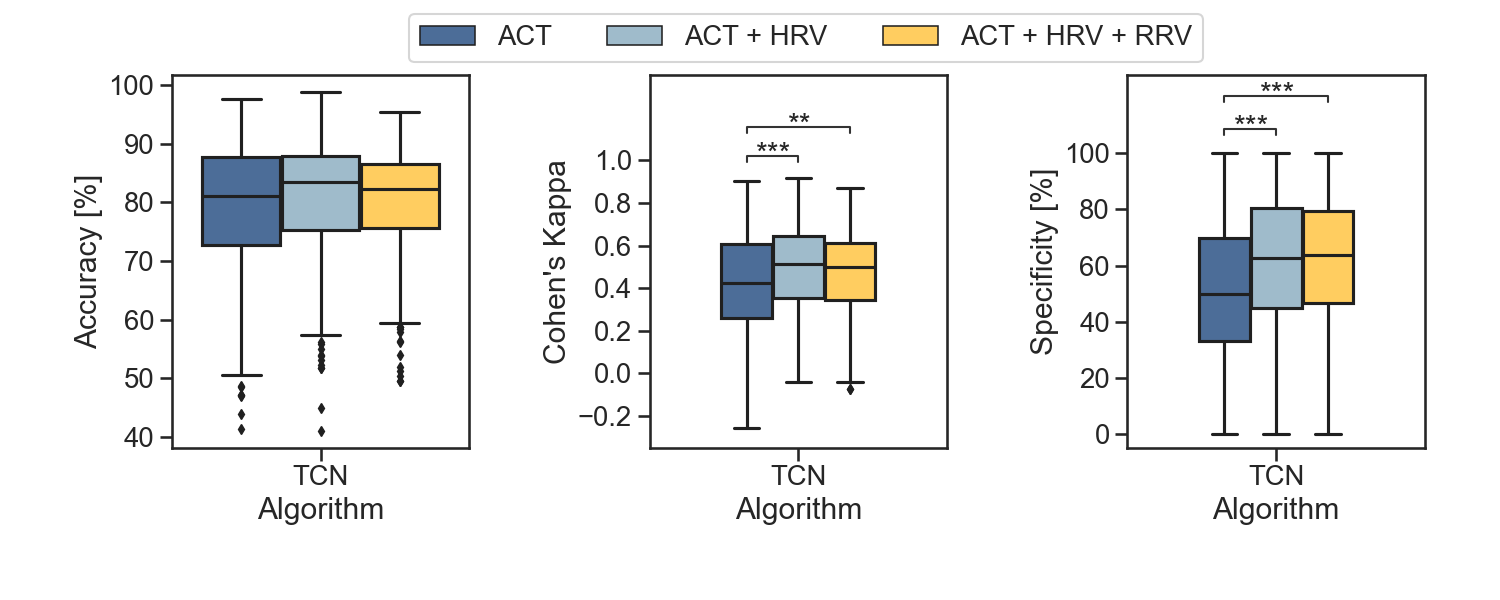

In [20]:
plot_algorithm_result(df_metric, "TCN")

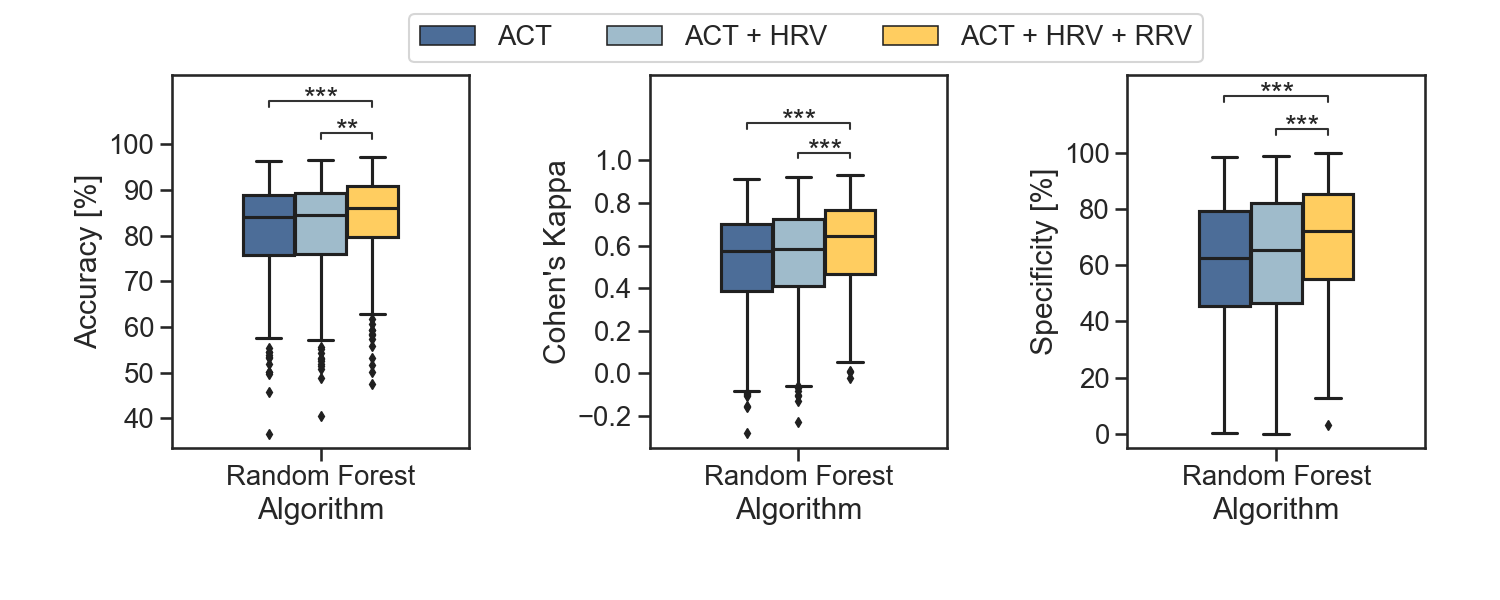

In [21]:
plot_algorithm_result(df_metric, "Random Forest")